<a href="https://colab.research.google.com/github/LxYuan0420/aws-machine-learning-university-accelerated-nlp/blob/master/colab_notebooks/MLA_NLP_Lecture2_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/Colab Notebooks/git/aws-machine-learning-university-accelerated-nlp/colab_notebooks

/gdrive/MyDrive/Colab Notebooks/git/aws-machine-learning-university-accelerated-nlp/colab_notebooks


**Machine Learning Accelerator - Natural Language Processing - Lecture 2**

Linear Regression Models and Regularization
In this notebook, we go over Linear Regression methods (with and without regularization: LinearRegression, Ridge, Lasso, ElasticNet) to predict the log_votes field of our review dataset.

1. Reading the dataset
1. Exploratory data analysis
1. Stop word removal and stemming
1. Train - Validation Split
1. Data processing with Pipeline and ColumnTransform
1. Train the regressor
1. Fitting Linear Regression models and checking the validation performance Find more details on the classical Linear Regression models with and without regularization here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
1. Ideas for improvement


Overall dataset schema:

1. reviewText: Text of the review
1. summary: Summary of the review
1. verified: Whether the purchase was verified (True or False)
1. time: UNIX timestamp for the review
1. rating: Rating of the review
1. log_votes: Logarithm-adjusted votes log(1+votes)

**1. Reading the dataset**

In [4]:
import pandas as pd

df = pd.read_csv('../data/examples/AMAZON-REVIEW-DATA-REGRESSION.csv')
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


**2. Exploratory data analysis**

In [5]:
df["log_votes"].min()

0.0

In [6]:
df["log_votes"].max()

7.799753318287247

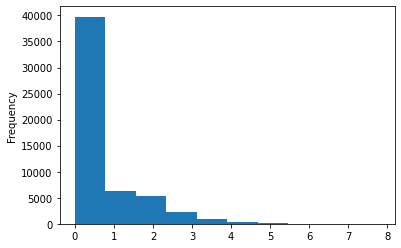

In [7]:
import matplotlib.pyplot as plt

df['log_votes'].plot.hist()
plt.show()

In [8]:
df.isna().sum()

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64

**3. Text Processing: Stop words removal and stemming**


In [9]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:

import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

**4. Train - validation Split**

9/1 split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "rating"]],
                                                  df["log_votes"],
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state=42)

In [12]:
print("Processing the reviewText field")

X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())


Processing the reviewText field


In [13]:
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

**5. Data processing with Pipeline and ColumnTransform**

In the previous examples, we have seen how to use pipeline to prepare a data field for our machine learning model. This time, we will focus on multiple fields: numeric and text fields. We are using linear regression model from Sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model.

For the numerical features pipeline, the numerical_processor below, we use a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
For the numerical features pipeline, the text_processor below, we use CountVectorizer() for the text fields.
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [14]:
numerical_features = ["time", "rating"]
text_features = ["summary", "reviewText"]

model_features = numerical_features + text_features
model_target = "log_votes"

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Column Transformer
numerical_processor = Pipeline([("num_scalar", MinMaxScaler())])

# preprocess text features
text_preprocessor_0 = Pipeline([("text_vect_0", CountVectorizer(binary=True, max_features=50))])
text_preprocessor_1 = Pipeline([("text_vect_1", CountVectorizer(binary=True, max_features=150))])

data_preprocessor = ColumnTransformer([
    ("numerical_pre", numerical_processor, numerical_features),
    ("text_pre_0", text_preprocessor_0, text_features[0]),
    ("text_pre_1", text_preprocessor_1, text_features[1])
])


# Pipeline 
pipeline = Pipeline([
    ("data_preprocessing", data_preprocessor),
    ("lr", LinearRegression())
])

In [18]:
pipeline

Pipeline(memory=None,
         steps=[('data_preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical_pre',
                                                  Pipeline(memory=None,
                                                           steps=[('num_scalar',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                  

**6. Train Regressor**

In [19]:
pipeline.fit(X_train[model_features], y_train.values)

Pipeline(memory=None,
         steps=[('data_preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical_pre',
                                                  Pipeline(memory=None,
                                                           steps=[('num_scalar',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                  

**7. Fitting Linear Regression models and checking the validation performance**

7.1 LinearRegression
Let's first fit LinearRegression from Sklearn library, and check the performance on the validation dataset. Using the coef_ atribute, we can also print the learned weights of the model.

Find more details on LinearRegression here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lrRegressor_val_predictions = pipeline.predict(X_val[model_features])
print("LinearRegression on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lrRegressor_val_predictions),r2_score(y_val, lrRegressor_val_predictions)))

LinearRegression on Validation: Mean_squared_error: 0.648439,  R_square_score: 0.362022


**7.2 Ridge (Linear Regression with L2 regularization)**

Let's now fit Ridge from Sklearn library, and check the performance on the validation dataset.

Find more details on Ridge here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

To improve the performance of a LinearRegression model, Ridge is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$
where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

ridge_pipeline = Pipeline([
    ("data_preprocessing", data_preprocessor),
    ("ridge", Ridge(alpha=100))
])

ridge_pipeline.fit(X_train[model_features], y_train.values)
ridgeRegressor_val_predictions = ridge_pipeline.predict(X_val[model_features])

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

Ridge on Validation: Mean_squared_error: 0.649729,  R_square_score: 0.360753


**7.3 LASSO (Linear Regression with L1 regularization)**

Let's also fit Lasso from Sklearn library, and check the performance on the validation dataset.

Find more details on Lasso here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Lasso is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$
where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$.

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with Lasso, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [22]:

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with Lasso regression model
lasso_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lasso', Lasso(alpha = 0.001))
])

lasso_pipeline.fit(X_train[model_features], y_train.values)
lassoRegressor_val_predictions = lasso_pipeline.predict(X_val[model_features])

print("Lasso on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lassoRegressor_val_predictions),r2_score(y_val, lassoRegressor_val_predictions)))

Lasso on Validation: Mean_squared_error: 0.651244,  R_square_score: 0.359263


**7.4 ElasticNet (Linear Regression with L2 and L1 regularization)**

Let's finally try ElasticNet from Sklearn library, and check the performance on the validation dataset.

Find more details on ElasticNet here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

ElasticNet is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$
and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with ElasticNet regression model
elastic_net_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('elastic_net', ElasticNet(alpha = 0.001, l1_ratio = 0.1))
])

elastic_net_pipeline.fit(X_train[model_features], y_train.values)
enRegressor_val_predictions = elastic_net_pipeline.predict(X_val[model_features])

print("ElasticNet on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val, enRegressor_val_predictions)))

ElasticNet on Validation: Mean_squared_error: 0.648996,  R_square_score: 0.361474
